In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Conv2D, Dense, MaxPool2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K

In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

training_set = train_datagen.flow_from_directory('new_dataset/train_test',
                                                 target_size = (256, 256),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

Found 12353 images belonging to 2 classes.


In [4]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory('new_dataset/validation',
                                            target_size = (256, 256),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 7104 images belonging to 2 classes.


In [5]:
def dfd_image(input_shape, units):
    model = tf.keras.Sequential();
    
    model.add(Conv2D(filters=16, padding="same", kernel_size=3, activation='relu', strides=2, input_shape=input_shape))
    model.add(MaxPool2D(pool_size=2, strides=2))
    
    model.add(Conv2D(filters=32, padding="same", kernel_size=3, activation='relu', strides=2, input_shape=input_shape))
    model.add(MaxPool2D(pool_size=2, strides=2))
    
    model.add(Conv2D(filters=64, padding="same", kernel_size=3, activation='relu', strides=2, input_shape=input_shape))
    model.add(MaxPool2D(pool_size=2, strides=2))
    
    model.add(Flatten())
    
    model.add(Dense(units=128, activation='relu'))
    
    model.add(Dense(units, kernel_regularizer=l2(0.01), activation='linear'))
    
    return model

In [6]:
input_shape = (256, 256, 3)

In [7]:
model = dfd_image(input_shape, units=1)

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0

In [9]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision * recall)/(precision + recall + K.epsilon()))

In [10]:
metrics = ['accuracy', f1_score_m, precision_m, recall_m]

model.compile(optimizer = 'adam',
              loss = 'hinge',
              metrics = metrics)

In [11]:
history = model.fit(x = training_set, validation_data = test_set, epochs = 15)

Epoch 1/15
387/387 [==============================] - 161s 402ms/step - loss: 0.6203 - accuracy: 0.7201 - f1_score_m: 0.7541 - precision_m: 0.7857 - recall_m: 0.7771 - val_loss: 0.3631 - val_accuracy: 0.8549 - val_f1_score_m: 0.8697 - val_precision_m: 0.9173 - val_recall_m: 0.8324
Epoch 2/15
387/387 [==============================] - 140s 361ms/step - loss: 0.3735 - accuracy: 0.8297 - f1_score_m: 0.8360 - precision_m: 0.9131 - recall_m: 0.7864 - val_loss: 0.4303 - val_accuracy: 0.7486 - val_f1_score_m: 0.7294 - val_precision_m: 0.9925 - val_recall_m: 0.5847
Epoch 3/15
387/387 [==============================] - 140s 361ms/step - loss: 0.2870 - accuracy: 0.8714 - f1_score_m: 0.8793 - precision_m: 0.9442 - recall_m: 0.8323 - val_loss: 0.4256 - val_accuracy: 0.7589 - val_f1_score_m: 0.7468 - val_precision_m: 0.9749 - val_recall_m: 0.6129
Epoch 4/15
387/387 [==============================] - 137s 353ms/step - loss: 0.2485 - accuracy: 0.8889 - f1_score_m: 0.8971 - precision_m: 0.9531 - recal

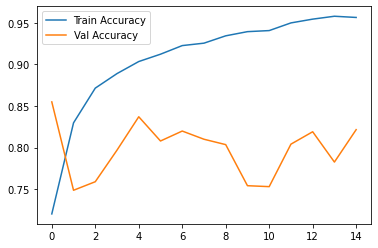

<Figure size 432x288 with 0 Axes>

In [12]:
# plotting the accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.show()
plt.savefig('Acc and Val_acc')

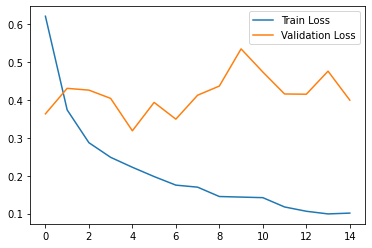

<Figure size 432x288 with 0 Axes>

In [13]:
# plotting the loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()
plt.savefig('Loss and Val_loss')

In [14]:
path = 'Weights_CNN_SVM/model_weights'
model.save_weights(path)

In [15]:
model.save('CNN_SVM_Model/cnn_svm_model.h5')

In [16]:
model.evaluate(test_set)

222/222 [==============================] - 13s 58ms/step - loss: 0.3992 - accuracy: 0.8215 - f1_score_m: 0.8344 - precision_m: 0.9194 - recall_m: 0.7713


[0.39923733472824097,
 0.8215090036392212,
 0.8344465494155884,
 0.9194343686103821,
 0.7713012099266052]